# 멀티모달 RAG 실습
- 모든 모달리티를 하나의 기본 모달리티로 표현하는 방식을 사용해 실습합니다.
### tesseract 설치
  - PDF파일에서 문자열을 추출하는 데 필요한 광학 문자 인식(OCR) 라이브러리 입니다. 
#### Windows 
- tesseract github에서 내려 받을 수 있습니다.  
- https://github.com/UB-Mannheim/tesseract/wiki
- 설치 중에 Additional script data( Hangul script와 Hangul vertical script 체크)
- Additional language data(download) 에서 korean 체크
- 시스템 변수 : C:\Program Files\Tesseract-OCR 추가
- CMD창에서 tesseract --version 입력
#### Mac 
```shell
brew install tesseract
```
#### Linux : 
```shell
sudo apt install tesseract-ocr
sudo apt install libtesseract-dev
```

### poppler 설치
- poppler은 PDF 렌더링과 처리에 필요한 라이브러리입니다.
#### Windows
- poppler github에서 내려받을수 있습니다.
- 압축을 풀고
- 예) C:\utils\poppler-24.08.0\Library\bin를 환경변수로 등록
- 환경변수로 등록하고 powershell에서 pdftoppm -h 명령어가 올바르게 동작한다면 성공적으로 설치한 것입니다.
- https://github.com/oschwartz10612/poppler-windows/releases
### Mac
```shell
brew install poppler
```
### Linux
```shell
sudo apt-get install poppler-utils
```

### unstructured 설치
- tesseract와 poppler를 이용하여 PDF의 전체적인 처리를 수행하는 라이브러리인 unstructured를 설치
```shell
uv add unstructured[all-docs]
```

## 구글 코랩에서 설치
- 구글 코랩은 우분트 운영체제 위에서 동작하도록 구성되어 있습니다.
- Linux 가이드를 따라하면서 설치할 수 있습니다.
```shell
!sudo apt install tesseract-ocr
!sudo apt install labtesseract-dev
!sudo apt-get install poppler-utils
!pip install -U "unstructured[all-docs]"
```

In [15]:
from dotenv import load_dotenv
load_dotenv()

True

### 데이터 전처리
- 검색에 활용할 PDF 파일의 전처리를 진행하여 벡터 저장소에 저장하는 작업을 진행합니다.
- PDF 내에는 텍스트와 이미지, 테이블 데이터등 다양한 유형의 데이터가 존재합니다.
- 이를 모두 한번에 추출한 뒤, 분류하여 저장하는 작업을 진행합니다.

### unstructured 라이브러리
- 텍스트 전처리 작업에 nltk를 사용하므로, 이에 필요한 데이터를 다음과 같이 다운로드 합니다.

In [15]:
import nltk

# nltk 필요 데이터 다운로드
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bbang\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\bbang\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

- 이어서 partition_pdf 함수를 사용하여 요소 추출을 진행합니다.

In [16]:
from unstructured.partition.pdf import partition_pdf

# PDF에서 요소 추출
raw_pdf_elements = partition_pdf(
    filename="data/sample.pdf",
    extract_images_in_pdf=True,
    extract_image_block_types=["Image", "Table"],
    chunking_strategy="by_title",
    extract_image_block_output_dir="data",
    languages=["eng", "kor"]
)

CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox
CropBox missing from /Page, defaulting to MediaBox


- filename: 분석하고자 하는 PDF 파일 경로를 지정합니다.
- extract_images_in_pdf: PDF안에 이미지가 있다면 이미지를 추출합니다.
- infer_table_structure: PDF안에 테이블이 있다면 테이블을 추출합니다.
- chunking_strategy: 텍스트를 조각낼 전략을 선택합니다. basic은 섹션 구분 없이 글자 수에 따라 조각 내고, by_title은 페이지 또는 섹션 경계에 따라 조각냅니다.
- extract_image_block_output_dir: 추출한 이미지를 저장할 경로를 설정합니다.

- https://docs.unstructured.io/open-source/core-functionality/chunking

- 다음은 이렇게 추출한 요소들 중, 테이블과 텍스트를 분리하여 저장하는 코드입니다.
- unstructured 라이브러리에서 추출된 데이터의 유형을 검사해 이미지와 테이블 구조를 추출합니다.
- 추출된 element의 type 문자열을 검사했을 때 unstructured.documents.elements.Table이 포함되어 있으면 테이블
- unstructured.documents.elements.CompositeElement가 포함되어 있으면 텍스트 입니다.

In [17]:
# 텍스ㅌ, 테이블 추출
tables = []
texts = []

for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        tables.append(str(element)) # 테이블 요소 추가
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        texts.append(str(element)) # 텍스트 요소 추가

In [29]:
tables[0]

'전년 대비(42주) 2023년 구분 2023년 증감 2024년 (1. 1.∼12. 31.) (%) (1. 1.∼10. 19.) (1. 1.∼10. 21.) 630 (100.0) 673 (100) 전체 663 (100.0) △5.0% 남자 성별 569 (84.5) 526 (83.5) 560 (84.5) △6.1% 1.0% 104 (15.5) 여자 103 (15.5) 104 (16.5) △60.0% 2 ( 0.3) 5 ( 0.7) 5 ( 0.8) 연령 0-9세 20 ( 3.2) 31 ( 4.6) 30 ( 4.5) 10-19세 △33.3% 20-29세 200 (30.2) 209 (33.2) 4.5% 201 (29.9) 30-39세 △18.2% 110 (16.6) 111 (16.5) 90 (14.3) △7.7% 104 (15.7) 96 (15.2) 107 (15.9) 40-49세 118 (17.5) 115 (17.3) △13.9% 50-59세 99 (15.7) 73 (11.6) 60-69세'

In [24]:
texts[0]

'42주차 (10.13.~10.19.)\n\n| 국 내 발생 | 해 외 유입 주차 ㅣ 전체\n\n주차\n\n국내발생 해외유입\n\n전체'

### 멀티 벡터 검색기
- 추출한 요소들을 벡터화하여 저장하고, 이를 통해 멀티모달 데이터를 검색할 수 있는 멀티-벡터 검색기를 구성해보겠습니다.

### 텍스트 및 테이블 요약
- 추출한 요소들은 목잡한 테이블과 텍스트를 그대로 읽은 데이터이기 때문에 복잡하고 가시성 떨어지는 모양을 띠고 있습니다.
- 이를 LLM에 제공하여 텍스트와 테이블에 대한 요약문을 생성하겠습니다.

In [35]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

# 프롬프트 설정
prompt_text = """당신은 표와 텍스트를 요약하여 검색할 수 있도록 돕는 역할을 맡은 어시스턴트입니다.
이 요약은 임베딩되어 원본 텍스트나 표 요소를 검색하는 데 사용될 것입니다.
표 또는 텍스트에 대한 간결한 요약을 제공하여 검색에 최적화된 형태로 만들어 주세요.
표 또는 텍스트 {element}"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# 텍스트 요약 체인
model = ChatOpenAI(model="gpt-4o-mini", temperature=0)
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

# 제공된 텍스트에 대해 요약을 할 경우
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
# 요약을 원치 않을 경우
# text_summaries = texts

# 제공된 테이블에 적용
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [36]:
table_summaries[0]

'**2023년 성별 및 연령대별 통계 요약**\n\n- **전체 인원**: 663명 (2023년), 전년 대비 5.0% 감소\n  - **남자**: 560명 (84.5%), 전년 대비 6.1% 감소\n  - **여자**: 103명 (15.5%), 전년 대비 60.0% 감소\n\n- **연령대별 분포**:\n  - **0-9세**: 30명 (4.5%), 전년 대비 33.3% 감소\n  - **10-19세**: 20명 (3.2%), 전년 대비 33.3% 감소\n  - **20-29세**: 201명 (29.9%), 전년 대비 4.5% 증가\n  - **30-39세**: 90명 (14.3%), 전년 대비 7.7% 감소\n  - **40-49세**: 118명 (17.5%), 전년 대비 13.9% 감소\n  - **50-59세**: 99명 (15.7%), 전년 대비 11.6% 감소\n  - **60-69세**: 데이터 없음\n\n이 요약은 2023년 성별 및 연령대별 인원 변화를 간결하게 나타내며, 검색 최적화를 위해 주요 수치와 증감률을 포함하고 있습니다.'

In [37]:
text_summaries[0]

'**42주차 (10.13.~10.19.) 요약:**\n\n- **국내 발생:** 해당 주차의 국내 발생 수치\n- **해외 유입:** 해당 주차의 해외 유입 수치\n- **전체:** 국내 발생과 해외 유입을 합한 전체 수치\n\n이 요약은 42주차의 감염병 발생 현황을 간결하게 나타내며, 검색 최적화를 위해 필요한 정보를 포함하고 있습니다.'

### 이미지 요약
- 오픈AI에서 지원하는 많은 모델 중 비전, 즉 이미지를 다룰 수 있는 모델은 gpt-4o 모델입니다.

#### 오픈AI의 MLLM
- 오픈 AI의 모든 LLM이 이미지 데이터를 처리할 수 있는 것은 아닙니다.
- 오픈 AI에서는 다음과 같이 이미지를 전달하는 여러 옵션을 제공하고 있습니다.

- 이미지 URL을 통해 모델에게 이미지 전달하기
```python
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content":[
                {"type": "text", "text": "What's in thie image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://~"
                    }                    
                }
            ]
        }
    ],
    max_tokens=300,
)
```

- 이미지를 base64 인코딩하여 모델에게 전달하기
```python
payload = {
    "model": "gpt-4o-mini",
    "messages" :[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What's in this image?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64, {base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens": 300,
}
resoinse = request.post("https://api.openai.com/v1/chat/completions", headers=headers, json=payload)
```

- 모델에게 여러장의 이미지 전달하기
```python
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content":[
                {
                    "type": "text",
                    "text": "What are in these images? Is there any difference between them?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://~"
                    }
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://~"
                    }
                }
            ]
        }
    ],
    max_tokens=300,
)
```

- 모델에게 이미지 퀄리티 지시하기
```python
response = client.chat.completions.create(
    model="gpt-4o-mini",
    messages=[
        {
            "role": "user",
            "content":[
                {"type": "text", "text": "What's in thie image?"},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": "https://~",
                        "detail": "high"
                    }                    
                }
            ]
        }
    ],
    max_tokens=300,
)
```


## 저해상도 또는 고해상도 이미지
- detail 파라미터를 조정하여 모델이 이미지를 처리하고 텍스트로 이해하는 방식을 제어할 수 있습니다.
- 기본적으로 모델은 auto설정을 사용하여 입력 이미지 크기를 확인한 후, low 또는 high모드를 자동으로 선택합니다.
- low: "저해상도" 모드를 활성화합니다. 이 모드에서는 모델이 512x512크기의 저해상도 이미지를 받고 이미지에 85토큰의 예산을 사용하여 표현합니다. 빠른 응답을 원하거나 높은 세부사항이 필요하지 않은 경우에 유용하며, 입력 토큰수를 절약할 수 있습니다.
- high: "고해상도" 모드를 활성화하며, 먼저 85토큰으로 저해상도 이미지를 확인한후 512x512타일당 170토큰을 사용하여 상세한 크롭을 생성합니다.
- auto: "자동" 모드에서는 입력 이미지 크기에 따라 low 또는 high 설정을 자동으로 선택하여 처리 속도와 이미지 세부 사항을 균형 있게 관리합니다.

- base64로 잌도딩된 이미지를 직접 보내는 방법을 사용하겠습니다.

In [47]:
import base64
import os

def encode_image(image_path) -> str:
    #이미지 base64 인코딩
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')
    
# 이미지의 base64 인코딩을 저장하는 리스트
image_base64_list = []

# 이미지를 읽어 base64 인코딩 후 저장
image_files = sorted(os.listdir("data"))
for img_file in image_files:
    if img_file.endswith(".jpg"):
        image_base64_list.append(encode_image(f"data/{img_file}"))   

print(len(image_base64_list))
print(f"{image_files[0]} : {image_base64_list[0]}")
print(f"{image_files[1]} : {image_base64_list[1]}")

30
figure-1-1.jpg : /9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAI/BnQDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD3vOaCcUg60N1qhMXcKNwptFBI7cKNwptFADtwo3Cm0UAO3CjcKbRQA7cKNwptFADtwo3Cm0UAO3CjcKbRQA7cKNwptFADtwo3Cm0UAO3CjcKbRQA7cKNwptFADtwo3Cm0UAO3CjcKbRQA7cKNwptF

## Base64 인코딩
- base64 인코딩은 이진 데이터를 텍스트 형식으로 변환하는 방법입니다.
- 6비트 단위로 데이터를 분할합니다.
- 64개의 문자집합을 사용합니다.
- 대문자 알파벳: A-Z(26개)
- 소문자 알파벳: a-z(26개)
- 숫자 : 0-9(10개)
- 추가 문자: +, /
- 데이터가 3바이트로 나누어지지 않으면,= 문자를 패딩으로 추가해 데이터의 길이를 맞춥니다.
- 패딩은 데이터를 원래 상태로 복원할때 도움이 됩니다.

- 이미지를 전달하여 텍스트 형식의 요약문을 생성해달라고 요청하겠습니다.

In [ ]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI

def image_summarize(img_base64: str) -> str:
    #이미지 요약
    chat = ChatOpenAI(model="gpt-4o-mini", temperature=0)
    prompt = """
    당신은 이미지를 요약하여 검색을 위해 사용할 수 있도록 돕는 어시스턴트입니다.
    이 요약은 임베딩되어 원본 이미지를 검색하는 데 사용됩니다.
    이미지 검색에 최적화된 간결한 요약을 작성하세요.
    """

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/jpeg;base64,{img_base64}",
                        }
                    }
                ]
            )
        ]
    )
    return msg.content

# 이미지 요약을 저장하는 리스트
image_summaries = []

for img_base64 in image_base64_list[:2]:
    image_summary = image_summarize(img_base64)
    image_summaries.append(image_summary)

#### 벡터 저장소에 추가
- 원본 데이터는 InMemoryStore입니다.
- 선언한 저장소들을 사용하여 멀티모달 데이터를 검색할 수 있는 멀티벡터 검색기 MultiVectorRetriever를 선언합니다.

In [ ]:
from langchain.retrievers import MultiVectorRetriever
from langchain_core.stores import InMemoryStore
from langchain_ollama import OllamaEmbeddings
from langchain_chroma import Chroma

# 분할한 텍스트들을 색인할 벡터 저장소
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OllamaEmbeddings(model="bge-m3"))

# 원본 문서 저장을 위한 저장소 선언
docstore = InMemoryStore()
id_key = "doc_id"

# 검색기
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=docstore,
    id_key=id_key,
)

- 각 원본 데이터를 식별할 수 있는 id가 필요한데 uuid_uuid4() 함수로 중복되지 않는 id값을 생성하여 사용하도록 하겠습니다.
- zip함수를 사용하면, 생성된 id와 원본데이터 쌍을 만들어 저장할 수 있습니다.

In [33]:
import uuid

# 원본 텍스트 데이터 저장
doc_ids = [str(uuid.uuid4()) for _ in texts]
retriever.docstore.mset(list(zip(doc_ids, texts)))

# 원본 테이블 데이터 저장
table_ids = [str(uuid.uuid4()) for _ in tables]
retriever.docstore.mset(list(zip(table_ids, tables)))

# 원본 이미지 데이터 저장
image_ids = [str(uuid.uuid4()) for _ in image_base64_list]
retriever.docstore.mset(list(zip(image_ids, image_base64_list)))

In [38]:
from langchain.schema.document import Document

#텍스트 요약 벡터 저장
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)

#테이블 요약 벡터 저장
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)

# 이미지 요약 벡터 저장
summary_images = [
    Document(page_content=s, metadata={id_key: image_ids[i]})
    for i, s in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_images)

['df479900-2dac-4bf8-8c31-45fe56c5d74f',
 '459a9c11-6ec0-4ddf-9b04-31eb9051a5fc']

## 멀티모달 RAG 구현
### 검색확인

In [39]:
docs = retriever.invoke(
    "말라리아 환자 발생 현황은 어떤가요?"
)
len(docs)

4

- 이미지와 텍스트를 분리하겠습니다.

In [40]:
from base64 import b64decode

def split_image_text_types(docs):
    # 이미지와 텍스트를 분리
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {
        "images": b64,
        "texts": text
    }

docs_by_type = split_image_text_types(docs)

In [41]:
len(docs_by_type["images"]), len(docs_by_type["texts"])

(1, 3)

- 이미지 확인


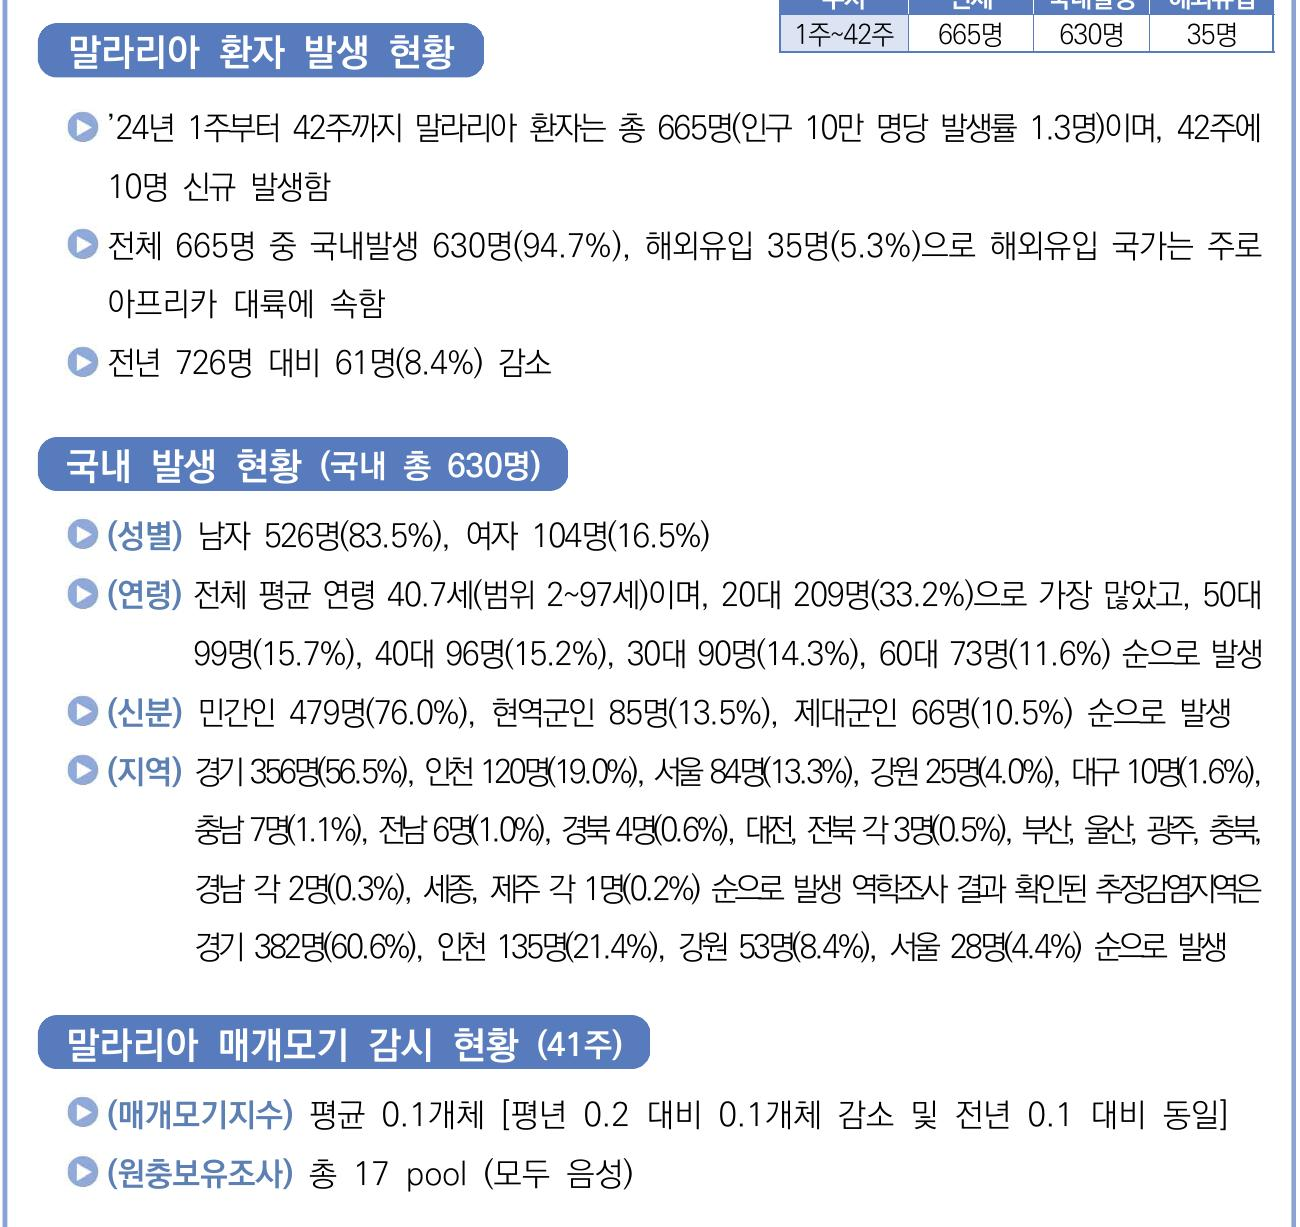

In [42]:
from IPython.display import display, HTML

def plt_img_base64(img_base64):
    # base64 인코딩된 이미지를 HTML로 표시
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}"/>'

    display(HTML(image_html))

plt_img_base64(docs_by_type["images"][0])

- 첫번째 문서

In [43]:
docs_by_type["texts"][0]

'1주~42주 665명 630명 35명 말라리아 환자 발생 현황 ’24년 1주부터 42주까지 말라리아 환자는 총 665명(인구 10만 명당 발생률 1.3명)이며, 42주에 10명 신규 발생함 전체 665명 중 국내발생 630명(94.7%), 해외유입 35명(5.3%)으로 해외유입 국가는 주로 아프리카 대륙에 속함 전년 726명 대비 61명(8.4%) 감소 국내 발생 현황 (국내 총 630명) (성별) 남자 526명(83.5%), 여자 104명(16.5%) (연령) 전체 평균 연령 40.7세(범위 2~97세)이며, 20대 209명(33.2%)으로 가장 많았고, 50대 99명(15.7%), 40대 96명(15.2%), 30대 90명(14.3%), 60대 73명(11.6%) 순으로 발생 (신분) 민간인 479명(76.0%), 현역군인 85명(13.5%), 제대군인 66명(10.5%) 순으로 발생 (지역) 경기 356명(56.5%), 인천 120명(19.0%), 서울 84명(13.3%),'

### 답변생성

In [44]:
from langchain.schema.runnable import RunnablePassthrough, RunnableLambda

def prompt_func(dict):
    format_texts = "\n".join(dict["context"]["texts"])
    text = f"""
    다음 문맥에만 기반하여 질문에 답하세요. 문맥에는 텍스트, 표, 그리고 아래 이미지가 포함될 수 있습니다:
    질문: {dict["question"]}

    텍스트와 표:
    {format_texts}
    """

    prompt = [
        HumanMessage(
            content=[
                {"type": "text", "text": text},
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{dict['context']['images'][0]}",
                    }
                }
            ]
        )
    ]

    return prompt

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# RAG 파이프라인
chain = (
    {"context": retriever | RunnableLambda(split_image_text_types), "question": RunnablePassthrough()}
    | RunnableLambda(prompt_func)
    | model
    | StrOutputParser()
)

# 랭체인의 러너블 객체
- 랭체인에서는 다양한 실행 논리를 정의하고 사용할 수 있는 여러 러너블 객체를 제공합니다.
- 그 중에서도 RunnableLambda, RunnablePassthrough는 사용자 정의 로직을 실행할 때 유용합니다.

## RunnableLambda
- 간단한 람다 함수를 실행할 수 있는 러너블입니다.
- 주로 빠르고 간결한 작업을 처리하기 위해 사용합니다.
- 파이썬의 람다 함수를 감싸서 랭체인의 실행 체인 내에서 동작하게 할 수 있습니다.
- 사용자가 원하는 임의의 함수를 정의하여 실행 가능
- 체인 내의 특정 단계에서 필요한 사용자 정의 로직을 추가하는 데 유용
- 데이터를 변형하거나 특정 로직을 적용하는 작업에 적합

In [26]:
from langchain.schema.runnable import RunnableLambda

#간단한 함수 정의
my_lambda = RunnableLambda(lambda x: x.upper())

#입력 처리
result = my_lambda.invoke("hello world")
print(result)  # "HELLO WORLD"

HELLO WORLD


## RunnablePassthrough
- 입력 그래도 출력하는 러너블입니다.
- 별도의 처리를 하지 않고 입력을 통과시키는 역할을 합니다.
- 특정 단계에서 입력을 그대로 넘기고 싶을 때 유용합니다.
- 입력을 가공하지 않고 그대로 전달
- 디버깅하거나 체인 내에서 특정 단계의 출력을 확인하고자 할 때 유용
- 기본적으로 아무 동작도 하지 않으므로 효율적

In [27]:
from langchain.schema.runnable import RunnablePassthrough
#입력을 그대로 통과시키는 passthrough 실행
passthrough = RunnablePassthrough()

result = passthrough.invoke("no change needed")
print(result)  # "no change needed"

no change needed


- 체인을 구성하였으므로, chain.invoke 함수를 사용해 파이프 라인을 실행할 수 있습니다.


In [45]:
chain.invoke(
    "말라리아 환자 발생 현황은 어떤가요?"
)

'말라리아 환자 발생 현황은 다음과 같습니다:\n\n- **총 환자 수**: 2024년 1주부터 42주까지 총 665명 발생 (인구 10만 명당 발생률 1.3명).\n- **신규 발생**: 42주에 10명 신규 발생.\n- **국내 발생**: 630명 (94.7%), **해외 유입**: 35명 (5.3%).\n- **전년 대비 변화**: 전체 환자 수는 전년 726명에서 61명(8.4%) 감소.\n- **성별**: 남자 526명(83.5%), 여자 104명(16.5%).\n- **연령대**: 평균 연령 40.7세, 20대가 209명(33.2%)으로 가장 많음.\n- **주요 발생 지역**: 경기 356명(56.5%), 인천 120명(19.0%), 서울 84명(13.3%).\n\n이와 같은 현황을 통해 말라리아 환자 수가 감소하고 있음을 알 수 있습니다.'